# **Dictionary (Sparse) Coder Implementation (from scratch):**

***author:** Mohamed Behery (with special thanks to <a href="https://www.youtube.com/@hugolarochelle">Hugo Larochelle</a>)*<br/>
***email:** m.behery@live.com*<br/>
***Phone/Skype Username:** +201062989114*

## **Implementation Methodology:**

This code is considered as a prologue for the work featured in the following academic paper:

  **Title:** *A salient dictionary learning framework for activity video summarization via key-frame extraction*</br>
  **URL:**   *https://doi.org/10.1016/j.ins.2017.12.020*

So it is preferrable if this code is to be reused if such paper is to be applied.

This code was developed after following the details and explanations provided by <a href="https://www.youtube.com/@hugolarochelle">Hugo Larochelle</a> in the following youtube videos:

- **Title:** Neural networks [8.1] : Sparse coding - definition</br>
  **URL:**   *https://www.youtube.com/watch?v=7a0_iEruGoM&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=60*</br>

- **Title:** Neural networks [8.2] : Sparse coding - inference (ISTA algorithm)</br>
  **URL:**   *https://www.youtube.com/watch?v=L6qhzWWtqQs&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=61*</br>

- **Title:** Neural networks [8.3] : Sparse coding - dictionary update with projected gradient descent</br>
  **URL:**   *https://www.youtube.com/watch?v=bhqNSjJ_A20&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=62*</br>

- **Title:**  Neural networks [8.4] : Sparse coding - dictionary update with block-coordinate descent</br>
  **URL:**   *https://www.youtube.com/watch?v=UMdNfhgPKTc&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=63*</br>

- **Title:**  Neural networks [8.5] : Sparse coding - dictionary learning algorithm</br>
  **URL:**   *https://www.youtube.com/watch?v=PzNMff7cYjM&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=64*</br>

- **Title:**  Neural networks [8.6] : Sparse coding - online dictionary learning algorithm</br>
  **URL:**   *https://www.youtube.com/watch?v=IePxTepLvQc&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=65*</br>

- **Title:**  Neural networks [8.7] : Sparse coding - ZCA preprocessing</br>
  **URL:**   *https://www.youtube.com/watch?v=eUiwhV1QcQ4&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=66*</br>

- **Title:**  Neural networks [8.8] : Sparse coding - feature extraction</br>
  **URL:**   *https://www.youtube.com/watch?v=FL81zSjAEEg&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH&index=67*</br>

For implementing the ZCA whitening stage the following articles were investigated:

- **Title:** What is the difference between ZCA whitening and PCA whitening?<br/>
  **URL:**   *https://stats.stackexchange.com/questions/117427/what-is-the-difference-between-zca-whitening-and-pca-whitening*

- **Title:** ZCA Whitening<br/>
  **URL:**   *https://martin-thoma.com/zca-whitening/*

#### **The code applies the following <font color='green'>features</font>:**

- Usage:
>1. Feature extraction via hypothesis inference.
>2. Data summarization into sorted key indices from the original data.

- ZCA Whitening stage learns ZCA weights (unit-vectors) from the training data only.

- Tolerance below which the training stops is a ratio not an absolute value for ensuring consistency across different datasets.

- The training process goes indefinitely in terms of epochs until the tolerance condition is not met, stopping the algorithm while training will skip the rest of the training process and will output the model at that moment irrespective of the tolerance condition and it will give no error.

- During summarization the algorithm outputs sorted indices only for two reasons:
>1. Allowing different modalities for summarization (check the <a href='https://doi.org/10.1016/j.ins.2017.12.020'>paper</a>).
>2. Data reduction via sub-sectioning, sub-sampling or using feature extraction aiming for a specific summarization modality. That is why **batch** gradient descent is only implemented.

- Dictionary learning via:
>1. Projected Gradient Descent
>2. Projected Block Coordinate Gradient Descent

- Hypothesis inference via gradient descent instead of calculating it using the expression $h = D^{-1} x$ because it requires the Dictionary matrix to be:
>1. singular with non-zero elements on the diagonal which the PyTorch has a bug that cannot be solved by adding a very small constant there, that bug doesn't exist on NumPy still it is a minor setback.</br></br>
>2. square with as many keys as the features available in our data, which goes against both our implementation for feature extraction and data summarization, this is the major setback.

## **Conclusion:**

- During data summarization, the reproducability of a consistent output should be investigated thoroughly for each data being used via tuning the input arguments to the constructor of the developed ***DictionaryCoder*** class.

- During feature extraction, this model is to be used as a preprocessing step in the data pipeline and the performance of the main model used for learning is to be tuned using the aforementioned arguments of said class as well.

In [1]:
import torch
from torch.optim import Adam

class DictionaryCoder(torch.nn.Module):

    def __init__(self, nkeys, zca = True, mode = 'block-coord-gd', regcoef = 1, learnrate = 1e-3, tolerance = 1e-4, summarize = True):

        assert mode in {'bcgd', 'gd'}
        
        super().__init__()
        self.__NKEYS = nkeys
        self.__ZCA = zca
        self.__MODE = mode
        self.__REGCOEF = regcoef
        self.__LEARNRATE = learnrate
        self.__TOLERANCE = tolerance
        self.__SUMMARIZE = summarize
        self.__DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    @property
    def nkeys(self):
        return self.__NKEYS
        
    @property
    def zca(self):
        return self.__ZCA
        
    @property
    def mode(self):
        return self.__MODE

    @property
    def regcoef(self):
        return self.__REGCOEF

    @property
    def learnrate(self):
        return self.__LEARNRATE

    @property
    def tolerance(self):
        return self.__TOLERANCE

    @property
    def summarize(self):
        return self.__SUMMARIZE

    @property
    def device(self):
        return self.__DEVICE

    @property
    def D(self):
        return self.__D

    @staticmethod
    def reconstruction_term(x, D, h):
        return 0.5 * torch.square(x - (D @ h.T).T).mean()
    
    @staticmethod
    def sparsity_term(h):
        return h.abs().mean()
    
    @staticmethod
    def project(D):
        return D / torch.sqrt(torch.square(D).sum(dim = 0)).unsqueeze(0)
    
    @staticmethod
    def summarize_x(x, D):
        cosine_similarity = x @ D
        closest_indices = cosine_similarity.argmax(0)
        return x[closest_indices].T, closest_indices

    def hypothesis_gd(self, x, h = None, epoch = None):

        n_datapoints, n_features = x.shape
        if h is None:
            h = torch.nn.Parameter(torch.randn(n_datapoints, self.__NKEYS).to(self.__DEVICE), requires_grad = True)
        optimizer = Adam(params = [h], lr = self.__LEARNRATE)
        
        epochs, previous = 0, None
        while True:
            
            epochs += 1
            
            cost_a = self.reconstruction_term(x, self.__D, h)
            cost_b = self.sparsity_term(h)
            cost = cost_a + self.__REGCOEF * cost_b
    
            if previous is None:
                previous = cost.item()
            current = cost.item()
                
            print(f'\r{f"Epoch {epoch}: (1) " if epoch else ""}Running Batch Gradient Descent on hypothesis (steps): {epochs} - [Reconstruction + Sparsity] Cost: {current:.05f}', end = '')
            if epochs > 1 and (previous - current) / previous < self.__TOLERANCE:
                print()
                break
                
            optimizer.zero_grad()
            cost.backward(retain_graph = True)
            optimizer.step()
            
            previous = current
            
        return h

    def projected_gradient_descent(self, x, h, epoch):

        D = torch.nn.Parameter(self.__D, requires_grad = True)
        
        optimizer = Adam(params = [D], lr = self.__LEARNRATE)
        
        epochs, previous = 0, None
        while True:
            
            epochs += 1
            
            cost = self.reconstruction_term(x, D, h)
    
            if previous is None:
                previous = cost.item()
            current = cost.item()
            
            print(f'\r{" " * len(f"Epoch {epoch}: ")}(2) Running Projected Gradient Descent on dictionary (D) (steps): {epochs} - [Reconstruction] Cost: {current:.05f}', end = '')
            if epochs > 1 and (previous - current) / previous < self.__TOLERANCE:
                print()
                return D.data, current
                
            optimizer.zero_grad()
            cost.backward(retain_graph = True)
            optimizer.step()
            
            D = self.project(D)
            
            previous = current
        
    def projected_block_coordinate_gradient_descent(self, x, h, epoch):
        D, h = torch.empty_like(self.__D), h.data
        A = h.T @ h
        B = x.T @ h
        for j in range(D.shape[1]):
            D[:,j] = (B[:,j] - self.__D @ A[:,j] + self.__D[:,j] * A[j,j])
        D = self.project(D)
        cost = self.reconstruction_term(x, D, h).item()
        print(f'{" " * len(f"Epoch {epoch}: ")}(2) Running Projected Block Coordinate Gradient Descent on dictionary (D) - [Reconstruction] Cost: {cost:.05f}', end = '')
        return D, cost
        
    def zca_whiten(self, x, train = True):
        if train:
            x_ = x - x.mean(0)
            C = (x_.T @ x_) / (x.shape[0] - 1)
            D, E = torch.linalg.eig(C)
            D, E = torch.diag(D.real), E.real
            self.__W_ZCA = E @ (1 / (D + 1e-7)) @ E.T
        return x @ self.__W_ZCA
        
    def train(self, x):

        def train_finish_routine():
            if self.__SUMMARIZE:
                self.__D, closest_indices = self.summarize_x(x, self.__D)
                unique_closest_indices = closest_indices.unique(sorted = True)
                print(f'\n\nUnique keys found: {unique_closest_indices.shape[0]}')
                out = unique_closest_indices.to('cpu')
            else:
                print()
                out = h.to('cpu')
            print('-' * 87 + '\n')
            return out

        x = x.to(self.__DEVICE)
        if self.__ZCA:
            x = self.zca_whiten(x, train = True)
        
        print(f'{"Summarizing Input" if self.__SUMMARIZE else "Training Dictionary"}:\n')
        n_datapoints, n_features = x.shape
        x = self.project(x.T).T
        self.__D = self.project(torch.randn(n_features, self.__NKEYS).to(self.__DEVICE)) if self.__SUMMARIZE else x[torch.randint(0, n_datapoints, (self.__NKEYS,))].T
        h = None
        epochs, previous = 0, None
        while True:
            try:
                epochs += 1
                h = self.hypothesis_gd(x, h, epochs)
                
                if epochs == 1:
                    previous = self.reconstruction_term(x, self.__D, h).item()

                if self.__MODE == 'gd':
                    self.__D, current = self.projected_gradient_descent(x, h, epochs)
                else:
                    self.__D, current = self.projected_block_coordinate_gradient_descent(x, h, epochs)
                    
                if self.__SUMMARIZE:
                    self.__D, _ = self.summarize_x(x, self.__D)
                    
                if (previous - current) / previous < self.__TOLERANCE:
                    return train_finish_routine()
                    
                previous = current
                print()
                
            except KeyboardInterrupt:
                return train_finish_routine()
        

    def forward(self, x):
        x = x.to(self.__DEVICE)
        if self.__ZCA:
            x = self.zca_whiten(x, train = False)
        return self.hypothesis_gd(x).to('cpu')

    @staticmethod
    def display_key_images(indices, dataset):
        from numpy import ceil
        print('\nKey Images:\n------------\n')
        ncells = int(ceil(len(indices) ** 0.5))
        fig, axs = plt.subplots(ncells, ncells, squeeze = False, figsize = (ncells, ncells))
        axs = axs.flatten()
        _ = [ax.axis('off') for ax in axs]
        for ax, image, label in zip(axs, dataset.data[indices], dataset.targets[indices]):
            ax.imshow(image, cmap = 'gray')
            ax.set_title(label.item())
        plt.tight_layout()
        plt.show()

Summarizing Input:

Epoch 1: (1) Running Batch Gradient Descent on hypothesis (steps): 3716 - [Reconstruction + Sparsity] Cost: 0.00081
         (2) Running Projected Gradient Descent on dictionary (D) (steps): 2 - [Reconstruction] Cost: 0.00064


Unique keys found: 10
---------------------------------------------------------------------------------------

Indices: [2724, 18557, 25995, 27576, 33086, 44694, 55688, 56932, 57927, 59949]

Key Images:
------------



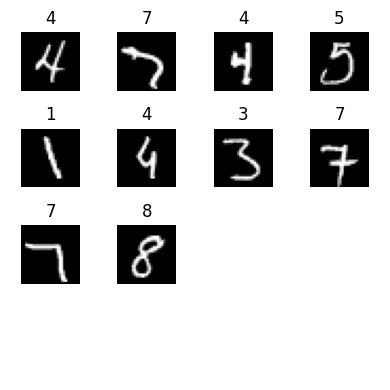

In [2]:
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from matplotlib import pyplot as plt

dataset = MNIST(root = './data', train = True, transform = ToTensor(), download = True)
x = dataset.data.flatten(-2) / 255
model = DictionaryCoder(nkeys = 10, zca = True, mode = 'gd', regcoef = 1, tolerance = 1e-4, summarize = True)
indices = model.train(x)
print(f'Indices: {indices.tolist()}')
model.display_key_images(indices, dataset)